In [107]:
import textacy
import pandas as pd
import spacy
from subject_verb_object_extract import findSVOs
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en_core_web_lg')

In [138]:
train1 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_test.csv')

np.random.seed(12345)
cur_train_indices = np.random.random_integers(0, train.shape[0], 100)
train = train.iloc[cur_train_indices]

/var/folders/lp/djryk53n11b_ww_n9xbjm4s80000gn/T/ipykernel_19181/3280733127.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 549367 + 1) instead
  cur_train_indices = np.random.random_integers(0, train.shape[0], 100)


In [139]:
train[train.notnull().apply(all, axis=1)]

,pairID,gold_label,Sentence1,Sentence2,Explanation_1,WorkerId,Sentence1_marked_1,Sentence2_marked_1,Sentence1_Highlighted_1,Sentence2_Highlighted_1
77285,3978422588.jpg#0r1n,neutral,Two women are walking on the sidewalk and one ...,Two women are going to visit a friend.,Walking on the sidewalk does not necessarily m...,A3MOH6X140NNB9,Two women are walking on the sidewalk and one ...,Two women are *going* *to* *visit* *a* *friend.*,{},"3,4,5,7,6"
135394,4830620136.jpg#4r1e,entailment,Three people are walking down a street.,Three individuals are walking.,People implies they are individuals.,A29GIYJ5MUHBPB,Three *people* are walking down a street.,Three *individuals* are walking.,1,1
87557,4574082050.jpg#2r1e,entailment,A large group of people gather outside a very ...,people are gathered on a busy road,Busy street is the same as busy road.,A3UYOMPM14B3WQ,A large group of people gather outside a very...,people are gathered on a *busy* *road*,"9,10","5,6"
86398,3960632488.jpg#3r1e,entailment,A man and a woman are sitting on the deck of a...,They are on the deck.,A man and a women can be condensed into the pr...,A3MMJ5K2RD4TPQ,A *man* and a *woman* are sitting on the deck...,*They* are on the deck.,"1,4",0
161222,447430161.jpg#2r1n,neutral,There are many people collected in a field.,The people are cult members.,Just because there are many people collected i...,A29N66WIWNN8JK,There are many people collected in a field.,The people *are* *cult* *members.*,{},"3,4,2"
...,...,...,...,...,...,...,...,...,...,...
214816,4760372043.jpg#1r1e,entailment,A man plays the guitar while sitting against a...,There is a man and a guitar.,'A man plays the guitar ' is a rephrasing of '...,A3GSN49YWM9CLD,*A* *man* *plays* *the* *guitar* while sittin...,*There* *is* *a* *man* *and* *a* *guitar.*,"2,4,3,1,0","0,1,3,5,4,6,2"
263605,3731739486.jpg#2r1n,neutral,3 women and a man waiting in line to board a y...,The women all have purses.,Just because they are women doesn't mean they ...,ANMD34DNHLOLC,3 women and a man waiting in line to board a y...,The women all have *purses.*,{},4
142597,229862312.jpg#4r1c,contradiction,a dog rolls in the grass.,The dog is dead outside.,A dead dog cant roll.,A36ZLUFEGBJGKA,a dog *rolls* in the grass.,The *dog* is *dead* outside.,2,"1,3"
164434,2710281519.jpg#0r1c,contradiction,A young couple in the front seat of a car offe...,The couple is out walking their dog.,the couple cannot be in the car if they are wa...,A23H5PTASRYHHB,A young couple in the *front* *seat* of a *ca...,The couple is out *walking* their *dog.*,"5,9,6","4,6"


In [140]:
def extract_SVO(text):
	tuples_list = list()
	tuples = textacy.extract.subject_verb_object_triples(text)
	if tuples:
		tuples_to_list = list(tuples)
		tuples_list.append(tuples_to_list)
	return tuples_list

In [141]:
def findLoc(text):
	for token in text:
		if token.dep_ == 'prep' and token.lemma_ in ['on', 'in']:
			return list(token.subtree)

In [142]:
def transform_svo_to_nlp(svos):
	res = list()
	for svo in svos:
		res.append([[token for token in nlp(sub_part)] for sub_part in svo])
	return res

In [143]:
SVO_list = []
train['nlp_s1'] = train['Sentence1'].apply(nlp)
train['nlp_s2'] = train['Sentence2'].apply(nlp)
train['svo_s1'] = train['nlp_s1'].apply(findSVOs).apply(transform_svo_to_nlp)
train['svo_s2'] = train['nlp_s2'].apply(findSVOs).apply(transform_svo_to_nlp)
train['loc_s1'] = train['nlp_s1'].apply(findLoc)
train['loc_s2'] = train['nlp_s2'].apply(findLoc)

In [144]:
train[['svo_s1', 'loc_s1', 'svo_s2', 'loc_s2']]

,svo_s1,loc_s1,svo_s2,loc_s2
77285,"[[[Two, women], [walking]], [[one, of], [carry...","[on, the, sidewalk]","[[[Two, women], [visit], [a, friend]]]",None
135394,"[[[Three, people], [walking]]]",None,"[[[Three, individuals], [walking]]]",None
87557,"[[[A, large, group, of, people], [gather]]]",None,"[[[a, busy, road], [gather], [people]]]","[on, a, busy, road]"
86398,"[[[A, man], [sitting]], [[a, woman], [sitting]]]","[on, the, deck, of, a, boat]","[[[They], [are]]]","[on, the, deck]"
161222,"[[[There], [are], [many, people]], [[many, peo...","[in, a, field]","[[[The, people], [are], [cult, members]]]",None
...,...,...,...,...
214816,"[[[A, man], [plays], [the, guitar]]]",None,"[[[There], [is], [a, man]], [[There], [is], [a...",None
263605,"[[[a, man], [waiting]], [[a, man], [board], [a...","[in, line]","[[[The, women, all], [have], [purses]]]",None
142597,[],"[in, the, grass]","[[[The, dog], [is]]]",None
164434,"[[[A, young, couple, in, the, front, seat, of,...","[in, the, front, seat, of, a, car]",[],None


In [9]:
for a in train.nlp_s1:
	for token in a:
		if token.dep_ == 'prep':
			print(list(token.subtree))

[on, a, horse]
[over, a, broken, down, airplane]
[on, a, horse]
[over, a, broken, down, airplane]
[on, a, horse]
[over, a, broken, down, airplane]
[at]
[at]
[at]
[on, skateboard]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[on, skateboard]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[on, skateboard]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[in, a, restaurant, setting]
[of, them]
[in, a, restaurant, setting]
[of, them]
[in, a, restaurant, setting]
[of, them]
[at, a, restaurant]
[at, a, restaurant]
[at, a, restaurant

In [10]:
temp = list()
for a in train.nlp_s1:
	temp1 = list()
	for token in a:
		if token.dep_ == 'prep' and token.lemma_ in ['on', 'in']:
			temp1.append(list(token.subtree))
	if len(temp1) != 0:
		temp.append(temp1)

In [11]:
len(temp)

603

## Extract Clothing

### Train Classifier

In [38]:
clothing_words = ['jeans', 'shirt', 'shirts', 'boot', 'boots', 'jacket', 'jackets', 'glove', 'gloves', 'shoe', 'shoes', 'sweater', 'sweaters', 'hat', 'hats', 'skirt', 'skirts', 'beanie', 'beanies', 'blouse', 'blouses', 'tank top', 'tank tops', 'shorts', 'trousers', 'pants', 'skirt', 'skirts', 'jumper', 'suit', 'suits', 'uniform', 'uniforms', 'dress', 'dresses', 'coat', 'coats', 'pullover', 'pullovers', 'sweatshirt', 'sweatshirts', 'cardigan', 'cardigans', 'sandle', 'sandles', 'raincoat', 'raincoats', 'swimsuit', 'scarf', 'hoodie']
other_words = [word for word in list(nlp.vocab.strings) if word not in clothing_words]

In [13]:
def cosine_sim_clothing_word(word, clothing_vectors):
	v1 = nlp.vocab[word].vector
	return max([np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2)) for v2 in clothing_vectors])

In [14]:
all_terms = pd.Series(nlp.vocab.strings)
clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

In [15]:
res = all_terms.apply(cosine_sim_clothing_word, clothing_vectors=clothing_vectors)

KeyboardInterrupt: 

In [ ]:
label = np.array([1 if word in clothing_words else 0 for word in all_terms])

In [ ]:
all_terms = all_terms[[not val for val in res.isna()]]
label = label[[not val for val in res.isna()]]
res = res[[not val for val in res.isna()]]
res = res.reset_index()
res = res.drop(["index"], axis=1)
all_terms = all_terms.reset_index()
all_terms = all_terms.drop(["index"], axis=1)

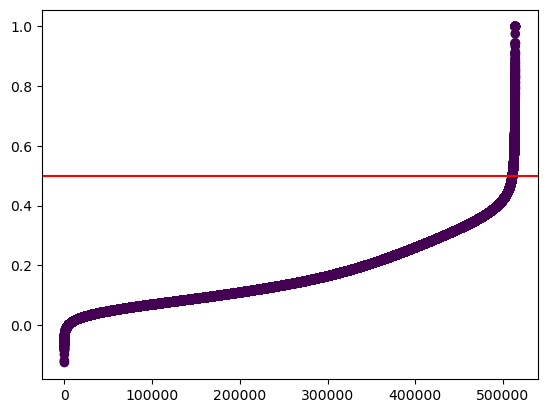

In [449]:
plt.scatter(range(len(res)), np.sort(res[0]), c=label)
plt.axhline(y=0.7, color="red")

In [39]:
def cosine_sim(v1, v2):
	return np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2))

clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

def findClothing(text):
	# https://stackoverflow.com/questions/53493052/any-elegant-solution-for-finding-compound-noun-adjective-pairs-from-sentence-by
	for token in text:
		if any(np.array([cosine_sim(token.vector, v2) for v2 in clothing_vectors]) > 0.7):
			comps = [j for j in token.children if j.pos_ in ['ADJ', 'NOUN', 'PROPN']]
			if len(comps) > 0:
				return comps + [token, ]
			else:
				return [token, ]

In [40]:
train['clo_s1'] = train['nlp_s1'].apply(findClothing)
train['clo_s2'] = train['nlp_s2'].apply(findClothing)

In [41]:
train[['svo_s1', 'loc_s1', 'clo_s1']]

,svo_s1,loc_s1,clo_s1
77285,"[[[Two, women], [walking]], [[one, of], [carry...","[on, the, sidewalk]",None
135394,"[[[Three, people], [walking]]]",None,None
87557,"[[[A, large, group, of, people], [gather]]]",None,None
86398,"[[[A, man], [sitting]], [[a, woman], [sitting]]]","[on, the, deck, of, a, boat]",None
161222,"[[[There], [are], [many, people]], [[many, peo...","[in, a, field]",None
...,...,...,...
113803,"[[[A, man, with, brown, hair], [playing], [a, ...",None,None
53374,"[[[people], [walk]]]",None,None
234645,[],"[in, grass]",None
130016,"[[[A, woman, in, mask], [sits]], [[a, man], [w...","[in, mask]","[Santa, suit]"


In [63]:
# How many svo structures are extracted per sentence 1?
train.svo_s1.apply(lambda x: len(x)).value_counts() / train.shape[0]

1    0.561
2    0.260
3    0.080
0    0.064
4    0.026
5    0.007
6    0.002
Name: svo_s1, dtype: float64

In [62]:
# How many svo structures are extracted per sentence 2?
train.svo_s2.apply(lambda x: len(x)).value_counts() / train.shape[0]

1    0.820
2    0.105
0    0.058
3    0.016
4    0.001
Name: svo_s2, dtype: float64

In [29]:
j = 0
for row in train.itertuples():
	i_s1 = 0
	i_s2 = 0
	if row.clo_s1 is not None:
		for svo in row.svo_s1:
			keep_index = [token.lemma_ not in [clo.lemma_ for clo in row.clo_s1] for token in svo[0]]
			train.iloc[j].svo_s1[i_s1][0] = np.array(row.svo_s1[i_s1][0])[keep_index]
			i_s1 += 1
	if row.clo_s2 is not None:
		for svo in row.svo_s2:
			keep_index = [token.lemma_ not in [clo.lemma_ for clo in row.clo_s2] for token in svo[0]]
			train.iloc[j].svo_s2[i_s2][0] = np.array(row.svo_s2[i_s2][0])[keep_index]
			i_s2 += 1
	j += 1

In [99]:
train.iloc[12]

pairID                                                   4793434809.jpg#3r1n
gold_label                                                           neutral
Sentence1                  A young adult is throwing a softball to home b...
Sentence2                                 The third baseman throws the ball.
Explanation_1              We have no idea if the third baseman is the on...
WorkerId                                                      A3EQ3SH24TYAP3
Sentence1_marked_1         A young adult is throwing a softball to home b...
Sentence2_marked_1                    The *third* *baseman* throws the ball.
Sentence1_Highlighted_1                                                   {}
Sentence2_Highlighted_1                                                  2,1
nlp_s1                     (A, young, adult, is, throwing, a, softball, t...
nlp_s2                           (The, third, baseman, throws, the, ball, .)
svo_s1                      [[[A, young, adult], [throwing], [a, softball]]]

In [47]:
def remove_clo_from_svo(clo, svo):
	if clo is not None:
		clo = clo.copy()
		svo = svo.copy()
		clo_lemmas = [cur_clo.lemma_ for cur_clo in clo]
		for i in range(len(svo)):
			svo[i][0] = [token for token in svo[i][0] if token.lemma_ not in clo_lemmas]
	return svo

In [48]:
remove_clo_from_svo(train.loc[52593].clo_s1, train.loc[52593].svo_s1)

[[[A, person], [stands]]]

In [157]:
def svo_to_string(svo):
	try:
		svo = svo[0][1]
		res = [token.text for token in svo]
		res = " ".join(res)
	except:
		res = ""
	return res

In [158]:
svo_to_string(train.svo_s1.iloc[10])

'speaks'

In [ ]:
train[['Sentence1', 'svo_s1',  'loc_s1', 'clo_s1', 'Sentence2', 'svo_s2', 'loc_s2', 'clo_s2']].head(20)

In [38]:
train[['Sentence1', 'clo_s1', 'Sentence2', 'clo_s2']].head(20)

,Sentence1,clo_s1,Sentence2,clo_s2
77285,Two women are walking on the sidewalk and one ...,None,Two women are going to visit a friend.,None
135394,Three people are walking down a street.,None,Three individuals are walking.,None
87557,A large group of people gather outside a very ...,None,people are gathered on a busy road,None
86398,A man and a woman are sitting on the deck of a...,None,They are on the deck.,None
161222,There are many people collected in a field.,None,The people are cult members.,None
150147,A woman studies the label on a food product.,None,The woman looks at the calorie count on the fo...,None
108158,"Two men in military uniform, a man in a tuxedo...","[military, uniform]",A group of people singing christmas carols.,None
47873,Two children on hands and knees on a wood floor.,None,Two kids take a nap on the comfy couch.,None
52593,A person stands in a vast field of glacial ice.,None,A person is sitting in the sand.,None
173468,People walk under trees as their purple leaves...,None,Some people are watching a movie in a theater.,None


In [36]:
svo_wrong = 6/20 # both SVO for both sentences are correct

In [37]:
loc_wrong = 9 / 40 # for each sentence separately
loc_recall = 18 / 20

In [39]:
clo_wrong = 2 / 40
clo_recall = 2 / 4 # both just missed some more pieces of clothing than the ones mentioned